In [1]:
from fastai.text.all import *
from pathlib import Path
import random
seed = 1
np.random.default_rng(seed)

pd.options.display.max_rows = 20
pd.options.display.max_columns = 8
%config InteractiveShell.ast_node_interactivity='last_expr_or_assign'

In [2]:
# use kwargs??
def get_oversampled_dls(data_path, seed=1, noise_limit=0.15, text_vocab=None):
    df = pd.read_csv(data_path)
    
    dls = TextDataLoaders.from_df(df, text_col='line_text', label_col='speaker', valid_pct=0.1, shuffle=True, seed=seed, text_vocab=text_vocab)
    
    df_train = dls.train.items
    max_dialog = df_train['speaker'].value_counts().max()

    dfs_oversampled = [df_train]
    for _, group in df_train.groupby('speaker'):
        rand_mult = random.uniform(1.0-noise_limit, 1.0 + noise_limit)
        sample_amt_to_max = max_dialog - len(group)
        dfs_oversampled.append(group.sample(int(sample_amt_to_max * rand_mult), replace=True))
        
    dls.train.items = pd.concat(dfs_oversampled)
    return dls

<Axes: >

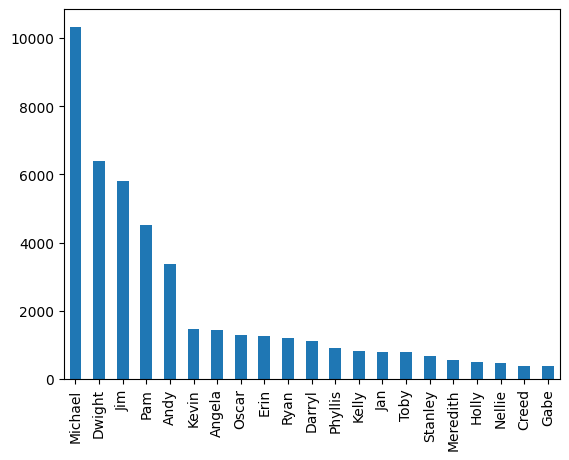

In [3]:
data_path = Path('../data/train21_shuffled.csv')
df = pd.read_csv(data_path)

df['speaker'].value_counts().plot(kind='bar')


In [4]:
dls_lm = TextDataLoaders.from_df(df, text_col='line_text', is_lm=True, valid_pct=0.1, shuffle=True, seed=seed)

In [5]:
dls_lm.show_batch()

,text,text_
0,"xxbos xxmaj remember that xxmaj halloween party you took me to once ? xxmaj the one where i started crying as soon as i walked in and i did n't stop crying ? xxbos xxmaj hi xxmaj michael ! xxbos xxmaj me mechanic not speak xxmaj english . xxmaj but he know what me mean when me say ' car no go ' , and we best friends . xxmaj so me","xxmaj remember that xxmaj halloween party you took me to once ? xxmaj the one where i started crying as soon as i walked in and i did n't stop crying ? xxbos xxmaj hi xxmaj michael ! xxbos xxmaj me mechanic not speak xxmaj english . xxmaj but he know what me mean when me say ' car no go ' , and we best friends . xxmaj so me think"
1,"remember ? xxmaj angela . xxmaj no . xxbos xxmaj cool . xxbos xxmaj the numbers are correct , xxmaj michael . xxbos xxmaj holy wow , that 's a big one . xxmaj alright , pencils down everyone , we got lice ! xxbos xxmaj go on . xxmaj have a nap . xxmaj lie down right here . xxmaj there 's a blanket in here . i used it earlier","? xxmaj angela . xxmaj no . xxbos xxmaj cool . xxbos xxmaj the numbers are correct , xxmaj michael . xxbos xxmaj holy wow , that 's a big one . xxmaj alright , pencils down everyone , we got lice ! xxbos xxmaj go on . xxmaj have a nap . xxmaj lie down right here . xxmaj there 's a blanket in here . i used it earlier myself"
2,", xxunk , c'm on ! xxmaj come on ! xxmaj come on . xxbos xxmaj vikram does n't have my people skills . xxbos xxmaj what ? xxbos xxmaj ok , [ lifts up cooked foot ] what does this look like to you xxmaj stanley ? ! xxbos xxmaj oh , xxmaj pam ! xxmaj toby says such nice things about you . xxbos xxmaj ugh . xxbos xxmaj animation","xxunk , c'm on ! xxmaj come on ! xxmaj come on . xxbos xxmaj vikram does n't have my people skills . xxbos xxmaj what ? xxbos xxmaj ok , [ lifts up cooked foot ] what does this look like to you xxmaj stanley ? ! xxbos xxmaj oh , xxmaj pam ! xxmaj toby says such nice things about you . xxbos xxmaj ugh . xxbos xxmaj animation ?"
3,"xxmaj nope we 're not brothers . xxbos xxmaj oh , no , so close . xxmaj oh . xxmaj no , we ca n't do that . xxmaj we ca n't do this . xxmaj ohh . xxbos xxmaj maybe i could sit in on this one with you ? xxmaj you know , that way i can cover you in case you need to xxunk or you just want another","nope we 're not brothers . xxbos xxmaj oh , no , so close . xxmaj oh . xxmaj no , we ca n't do that . xxmaj we ca n't do this . xxmaj ohh . xxbos xxmaj maybe i could sit in on this one with you ? xxmaj you know , that way i can cover you in case you need to xxunk or you just want another opinion"
4,"a decision even . xxbos xxmaj what no , wait ! xxmaj you said you were gon na help us ! xxbos xxmaj is this the same grill you grilled your foot on ? xxbos xxmaj nellie , xxmaj i 'm sorry , but i do n't feel comfortable being evaluated by someone i do n't know . xxbos xxmaj jelly beans . xxbos xxmaj yeah i asked the bus driver to","decision even . xxbos xxmaj what no , wait ! xxmaj you said you were gon na help us ! xxbos xxmaj is this the same grill you grilled your foot on ? xxbos xxmaj nellie , xxmaj i 'm sorry , but i do n't feel comfortable being evaluated by someone i do n't know . xxbos xxmaj jelly beans . xxbos xxmaj yeah i asked the bus driver to lock"
5,"i call with my magic sales fingers ? [ michael 's phone rings ] xxmaj michael xxmaj scott , head of sales . xxbos xxmaj what ? xxmaj why are we- xxbos xxmaj can i have everyone 's attention please ? xxmaj phyllis , xxmaj oscar , xxmaj ryan , who 's supposed to be dead , can i ask you all a question ? xxmaj do you all know what it","call with my magic sales fingers ? [ michael 's phone rings ] xxmaj michael xxmaj scott , head of sales . xxbos xxmaj what ? xxmaj why are we- xxbos xxmaj can i have everyone 's attention please ? xxmaj phyllis , xxmaj oscar , xxmaj ryan , who 's supposed to be dead , can i ask you all a question ? xxmaj do you all know what it 's"
6,"kevin and the xxmaj zits . xxbos xxmaj our prices are

### From fine tuning, it appears that drop_mult around 0.3, with wd=0.1 or lower is most approapriate for this dataset / language model

In [6]:
data_dir = Path('../data')
learn = language_model_learner(dls_lm, AWD_LSTM, metrics=[accuracy, Perplexity()], drop_mult=0.3, wd=0.1, path=data_dir)
learn.fit_one_cycle(8, 1e-2)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,3.875723,3.495511,0.316049,32.967133,00:26
1,3.437058,3.355901,0.330187,28.671432,00:25
2,3.295083,3.323213,0.334437,27.749369,00:25
3,3.201227,3.308441,0.336618,27.342457,00:25
4,3.130705,3.294459,0.338803,26.962812,00:25
5,3.057043,3.287009,0.340724,26.762703,00:25
6,2.994414,3.285241,0.341524,26.715431,00:25
7,2.955525,3.285059,0.341043,26.710552,00:25


In [7]:
# data_dir = Path('../data')
# scaling_factor=0.2

# for i in range(10):
#     dm = 0.1 + i*scaling_factor
    
#     print(f'Drop mult: {dm}')
#     learn = language_model_learner(dls_lm, AWD_LSTM, metrics=[accuracy, Perplexity()], drop_mult=dm, path=data_dir)
    
#     learn.fit_one_cycle(5, 1e-2)

# data_dir = Path('../data')
# scaling_factor=0.1

# for i in range(9):
#     reg = 0.1 + i*scaling_factor
    
#     print(f'Regularization: {reg}')
#     learn = language_model_learner(dls_lm, AWD_LSTM, metrics=[accuracy, Perplexity()], drop_mult=0.3, wd=reg, path=data_dir)
    
#     learn.fit_one_cycle(5, 1e-2)

In [8]:
encoder_fp = 'tmp_encoder_tst'
learn.save_encoder(encoder_fp)

In [10]:
dls_clas = get_oversampled_dls(data_path, seed=seed, text_vocab=dls_lm.vocab)

In [ ]:
## Create the TEST DF here, using FASTAIs tools

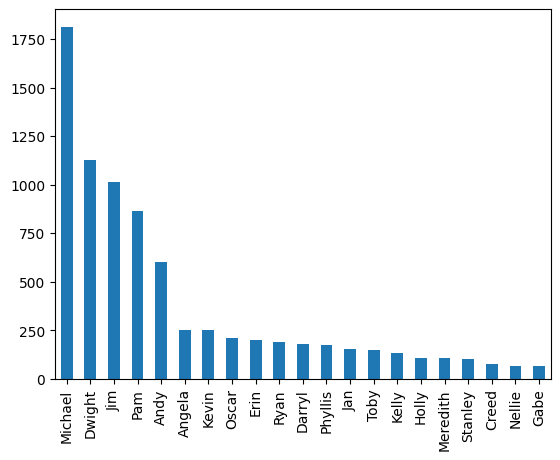

In [60]:
df_test = pd.read_csv(data_dir/'test21_shuffled.csv')
df_test['speaker'].value_counts().plot(kind='bar')

# we must tokenize first because test_dl is assuming text cols at col 'text'
# thus, my tokenize_df moves tokenized inputs to 'text' in the df
tokenized_df = tokenize_df(df_test, text_cols='line_text', tok_text_col='text')
test_dl = dls_clas.test_dl(tokenized_df[0], with_labels='True', label_col='speaker')

<Axes: title={'center': 'Train Distribution'}>

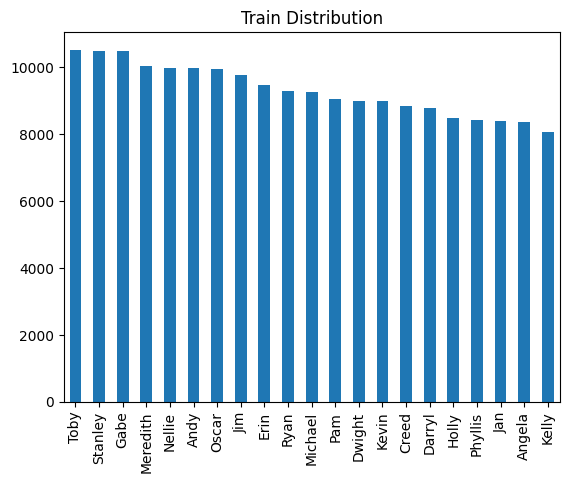

In [64]:
dls_clas.train.items['speaker'].value_counts().plot(kind='bar', title='Train Distribution')

<Axes: title={'center': 'Validation Distribution'}>

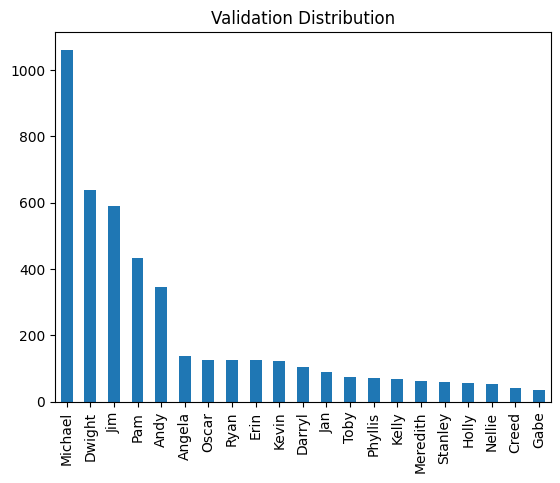

In [65]:
dls_clas.valid.items['speaker'].value_counts().plot(kind='bar', title='Validation Distribution')

In [66]:
dls_clas.show_batch()

,text,category
0,"xxbos xxmaj i 've really learned from the xxunk . xxmaj the great xxunk , xxmaj drew xxmaj xxunk , xxmaj ryan xxmaj xxunk , uh , the xxmaj xxunk guy not so much . xxmaj he 's more the signing , xxmaj wayne xxmaj xxunk . xxmaj um , xxmaj robin xxmaj williams . xxmaj oh , man , would i love to go head - to - head with him . xxmaj oh ! xxmaj that would be exciting . [ as xxmaj robin xxmaj williams ] ' hi . xxmaj i 'm xxmaj xxunk from xxmaj xxunk . ' xxmaj well , xxmaj i 'm xxmaj xxunk from xxmaj xxunk . xxmaj nanoo , nanoo . xxmaj xxunk , xxunk . [ as xxmaj robin xxmaj williams ] ' that 's xxmaj good morning , xxmaj vietnam ! ' xxmaj well , hello to you . xxmaj",Michael
1,"xxbos [ to the camera ] xxmaj can you get her ? xxmaj she 's right there . [ camera zooms in on xxmaj meredith at here desk ] xxmaj that is xxmaj meredith , the birthday girl . xxmaj and this … is xxmaj meredith 's card . xxmaj happy bird - day . [ laughs ] xxmaj um , let 's see . xxmaj jim , xxmaj jim wrote , ' meredith , i heard you 're turning xxunk , but , come on , you 're an accountant . xxmaj just fudge the numbers . ' xxmaj not bad , pretty funny , i do n't appreciate xxunk corporate fraud though . xxmaj uh , here 's the thing . xxmaj whatever i write here has to be really , really funny . xxmaj because people out there are expecting it . xxmaj i 've already set",Michael
2,"xxbos xxmaj pam , would you stand up for a sec ? [ sits in xxmaj pam 's chair ] xxmaj hmm . xxmaj see how relaxed i am ? i like this chair . [ slowly sinking into the chair ] xxmaj offers good support , it is xxunk correct … it 's a good chair . i think we 're spoiled because we do n't appreciate the things that we have . xxmaj you think kids in xxmaj africa have chairs ? xxmaj no . xxmaj they sit in big piles of garbage . xxmaj you think they have xxunk ? [ the chair has slowly xxunk itself almost to where xxmaj michael is not visible over the desk ] xxmaj they do n't have xxunk . xxmaj they do n't xxunk [ struggles to get up from xxmaj pam 's chair ] xxmaj gah ! xxmaj they",Michael
3,"xxbos xxmaj the pen delivery went amazing , and now xxmaj i 've got all these pens just waiting to be xxunk . xxmaj but xxmaj pam did not tell me to unpack the pens , and xxmaj i 'm not one of those people who 's just like , ' uh , sure . xxmaj i 'll accept the pens when they come in , and then as soon as your back 's turned , i unpack the pens and get all this credit as some great pen xxunk . xxmaj on the other hand ' they are just sitting here . xxmaj pam did n't tell me not to unpack them . xxmaj do n't want to be a busybody , but i do n't want to be a lazybones . xxmaj busybody , lazybones . xxmaj busybody , lazybones . xxmaj ahh ! xxmaj my brain is",Erin
4,"xxbos xxmaj well , now xxup ok , i know that this is probably not appropriate , but i need help . xxmaj because i want to play ball with my kids before i get too old . xxmaj and before that happens i need to get laid . xxmaj and before that happens i need to be in love . xxmaj and i do n't wanna hear ' ah xxrep 3 n … i ca n't help xxunk la la . ' xxmaj no . xxmaj no . xxmaj i 'm a catch and i am not going to be the one who got away . xxmaj so , this is what we 're going to do . xxmaj dwight is going to hand out index cards and i want you all to write down the name of an xxunk woman for me to date by the end of",Michael
5,"xxbos xxmaj my boss is coming in today , the lovely xxmaj jan levinson - gould will , well , no xxmaj gould . xxmaj the xxmaj gould has been [ makes xxunk neck hand motion ] xxunk , divorced . xxmaj um , the awkward part is that this will be the first time that we 'll be seeing each other since , well , uh , it was really nothing . xxmaj we just sort of got caught up in the moment . xxmaj the xxunk xxunk gives herself to the understanding , with xxunk good - looks , office manager . xxmaj just , uh , she did n't want it to continue for some reason . xxmaj it , we both , i did n't want it , we both did n't wa

In [67]:
learn = text_classifier_learner(dls_clas, AWD_LSTM, metrics=accuracy, drop_mult=0.5, path=data_dir)

In [68]:
learn.load_encoder(encoder_fp)

Use discriminative learning and gradual unfreezing to benefit from the LM fine tuning

In [69]:
learn.fit_one_cycle(1, 2e-2)

epoch,train_loss,valid_loss,accuracy,time
0,2.490053,2.495527,0.254451,00:09


In [70]:
learn.freeze_to(-2)
learn.fit_one_cycle(1, slice(1e-2/(2.6**4), 1e-2))

epoch,train_loss,valid_loss,accuracy,time
0,2.429282,2.454875,0.256029,00:10


In [71]:
learn.freeze_to(-3)
learn.fit_one_cycle(1, slice(5e-3/(2.6**4), 5e-3))

epoch,train_loss,valid_loss,accuracy,time
0,2.436427,2.421344,0.267072,00:15


In [72]:
learn.unfreeze()
learn.fit_one_cycle(2, slice(1e-3/(2.6**4),1e-3))

epoch,train_loss,valid_loss,accuracy,time
0,2.361897,2.406501,0.274735,00:19
1,2.357270,2.390748,0.285328,00:19


In [73]:
learn.save('ULMFit_test_model')

Path('../data/models/ULMFit_test_model.pth')

In [74]:
learn.fine_tune(5, 1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,2.315152,2.395574,0.284652,00:11


epoch,train_loss,valid_loss,accuracy,time
0,2.299512,2.390839,0.286229,00:19
1,2.299854,2.384798,0.283976,00:19
2,2.341598,2.384251,0.282173,00:19
3,2.287613,2.391004,0.280370,00:19
4,2.236520,2.409586,0.274059,00:19


In [75]:
learn.export('ULMFit_test_export')

### Training beyond this point appears to overfit

In [89]:
learn.validate(dl=test_dl)

(#2) [2.4081814289093018,0.26634320616722107]

In [76]:
interp = ClassificationInterpretation.from_learner(learn)

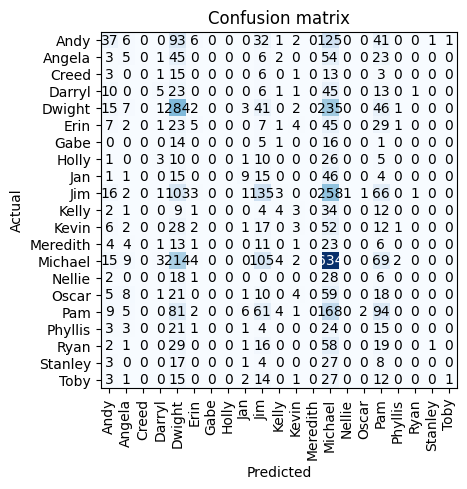

In [77]:
interp.plot_confusion_matrix()

In [78]:
learn.show_results()

,text,category,category_
0,"xxbos xxmaj toby actually gets xxunk from his ex - wife because she makes more , so that 's kind of embarrassing . xxmaj not that xxmaj i 'd mind , but it would never happen to me because i would make the marriage work . xxmaj people seem to like him because they think he 's one of us , but he 's not . xxmaj he 's this weird xxunk who just tells people , ' do n't do this , do n't do that . xxmaj hire this person for this reason . ' i would complain about him , but who would i go to , to complain about xxmaj toby ? xxmaj toby . xxmaj bias . xxmaj and what does he do about that ? xxmaj nothing . xxmaj because he 's xxmaj toby . xxmaj what kind of name is that ? xxmaj",Michael,Michael
1,"xxbos g xxrep 5 o d morning , xxunk - nashua ! xxmaj sales . xxmaj sales is what xxunk us together , today . xxmaj how do we deal with clients who say , ' frankly , my dear , i do n't give a damn … about paper ' and get them to ' show us the money ! ' xxmaj well , we are going to find out today . xxmaj show of hands . xxmaj how many of you are salesmen ? xxmaj let 's see the salesmen . [ some raise their hands ] xxmaj oh , okay . xxmaj well i know what the rest of you are thinking . xxmaj wow , yuck . xxmaj salesmen are the worst ! xxmaj they are awful . xxmaj they are so arrogant . xxmaj they think the whole place xxunk around them . xxmaj handsome",Michael,Michael
2,"xxbos i did n't watch the whole documentary . xxmaj after a few episodes , it was too painful . i kept wanting to scream at xxmaj pam . xxmaj it took me so long to do so many important things . xxmaj it 's just hard to accept that i spent so many years being less happy than i could have been . xxmaj jim was 5 feet from my desk and it took me four years to get to him . xxmaj it 'd be great if people saw this documentary and learned from my mistakes . xxmaj not that xxmaj i 'm a tragic person . xxmaj i 'm really happy now . xxmaj xxunk would xxunk make my heart xxunk if someone out there saw this and she said to herself ' be strong , trust yourself , love yourself . xxmaj xxunk your fears .",Pam,Dwight
3,"xxbos i understand . xxmaj it 's in a blind spot because xxmaj i 'm trained in several martial arts and one of them , uh , includes , uh , an awareness that the xxunk bring , uh , of anything on all sides of you . xxmaj it could be behind you or whatever . xxmaj this is directly in a blind spot , so xxmaj i 'm trained to respond xxunk to something right above my head . [ new take ] xxmaj this now i have an eye on . xxmaj you see , it 's on my xxunk and if i needed to block it , attack it , stop it somehow . [ does a martial arts move with his hands ] i could come right out . i mean , i know you 're doing your job , but … xxmaj documentary xxmaj",Dwight,Dwight
4,"xxbos xxmaj toby has been leaving radon xxunk everywhere , like he owns the place . xxmaj the first time i threw mine away , i thought it was an ant trap . [ finds radon kit in between his blinds in his office ] xxmaj but i figured xxmaj i 'd rather live with ants than with his creepy little disc . [ throws it away ] xxmaj the second time … i thought it was one of those , you know , those things you turn over and it xxunk . [ finds another radon kit on top of his cabinet ] xxmaj like a cow thing . xxmaj but upon closer xxunk , it was another ant trap , so i threw it away . xxmaj and the third time … i did it out of spite . [ takes radon kit from the top of the",Michael,Dwight
5,"xxbos xxmaj all right . xxmaj wow . xxmaj um , i am never going to forget today . xxmaj not a chance . i do n't think i could ever give back to you what you have given me today . xxmaj who here has done something stupid in their lives ? xxmaj like xxunk out on study hall or mix up the difference between ' a ' gym and ' b ' gym , that sort of thing ? xxmaj show of hands , anybody , yes , a bunch of you , okay . xxmaj well , me too , xxmaj i 've done something stupid which i would like to share . u xxrep 3 m . [ period bell 

In [79]:
learn.predict('I wanna eat hot dogs on the beach')

('Kevin',
 tensor(11),
 tensor([0.0530, 0.0182, 0.0215, 0.0702, 0.0133, 0.0481, 0.0037, 0.0130, 0.0062,
         0.0604, 0.0750, 0.1327, 0.0487, 0.0588, 0.0011, 0.0230, 0.1140, 0.1047,
         0.0739, 0.0473, 0.0128]))